In [68]:
import os
import pandas as pd
import numpy as np
import json
import pickle 
import torch
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_theme(style="ticks", font_scale=1.5)

# Investigation: difference in latSize compression across Chromosomes

## Overview final jobs

In [2]:
PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"

In [3]:
param_grid = ['hidden_layer_encoder_topology', 'latentSize', 'lr', 'dropout']
df_overview = pd.DataFrame(index=[f"chr{ele}" for ele in range(1,23)], columns=["num_cpgs"]+param_grid)

for CHR in [f"chr{ele}" for ele in range(1,23)]:
    ### Get number of input CpGs
    with open(os.path.join(PATH_data, f"{CHR}_train_methyl_array.pkl"), "rb") as f: train_dataset = pickle.load(f) #
    num_cpgs = train_dataset["beta"].shape[1]
    
    ### Parse parameter grid
    PATH_results = f"logs/finalModels/{CHR}"
    with open(f"{PATH_results}/param_grid.json", "r") as f: param = json.load(f)
        
    ### add to output dataframe
    df_overview.loc[CHR,"num_cpgs"] = num_cpgs
    df_overview.loc[CHR,"hidden_layer_encoder_topology"] = param["hidden_layer_encoder_topology"]
    df_overview.loc[CHR,"latentSize"] = param["latentSize"]
    df_overview.loc[CHR,"lr"] = param["lr"]
    df_overview.loc[CHR,"dropout"] = param["dropout"]
    
'''
Reduction by factor of... 
'''
df_overview["compressionFactor"] = df_overview["num_cpgs"] / df_overview["latentSize"]

df_overview#.sort_values(by="num_cpgs")

,num_cpgs,hidden_layer_encoder_topology,latentSize,lr,dropout,compressionFactor
chr1,29482,"[8840, 1770]",72,0.0001,0.1,409.472222
chr2,21984,"[6600, 1320]",60,0.0001,0.1,366.4
chr3,15547,"[4660, 930]",45,0.0001,0.1,345.488889
chr4,13100,"[3930, 790]",50,0.0001,0.1,262.0
chr5,15965,"[4790, 960]",38,0.0001,0.1,420.131579
chr6,23070,"[6920, 1380]",78,0.0005,0.1,295.769231
chr7,19599,"[5880, 1180]",70,0.0001,0.1,279.985714
chr8,13704,"[4110, 820]",88,0.0005,0.3,155.727273
chr9,6619,"[1990, 400]",88,0.0005,0.3,75.215909
chr10,15736,"[4720, 940]",52,0.0001,0.1,302.615385


Text(0, 0.5, 'Compression factor')

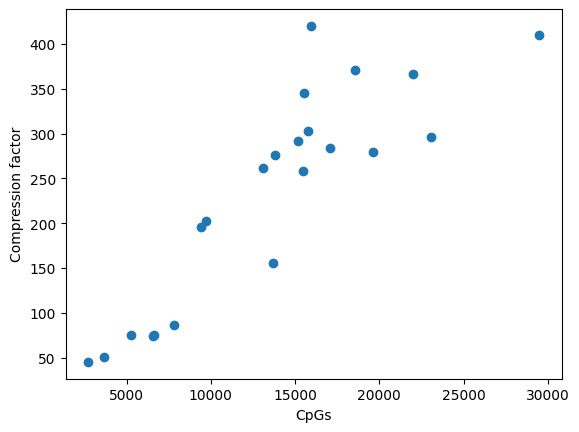

In [4]:
fig, ax = plt.subplots()
ax.plot(df_overview["num_cpgs"], df_overview["compressionFactor"], "o")
ax.set_xlabel("CpGs")
ax.set_ylabel("Compression factor")

## Plot: Compression vs reconstruction accuracy

In [5]:
from scipy.stats import pearsonr
def calc_r2(model, data_tensor):    
    model.eval()
    orig = data_tensor.cpu().detach().numpy()
    recon = model(data_tensor)
    # check if VAE or AE was used
    if isinstance(recon, tuple):
        recon = recon[0].cpu().detach().numpy()
    else:
        recon = recon.detach().numpy()
    r2 = []
    for i in range(recon.shape[1]):
        r2.append(pearsonr(orig[:,i], recon[:,i])[0])
    return np.array(r2).mean().round(3), np.array(r2).std().round(3)

In [6]:
'''Load Data'''
PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"
CHR = "chr6" 
with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

''' R2 for all chromosomes '''
mean_r2 = []
std_r2 = []
for CHR in [f"chr{i}" for i in range(1,23)]:
    with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
    test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)
    
    PATH_results = f"logs/finalModels/{CHR}"
    with open(f"{PATH_results}/param_grid.json", "r") as f: dict_bestModel = json.load(f)
    latSize = dict_bestModel["latentSize"]
    name = f"latSize_{latSize}"
    path = f"{PATH_results}/{name}"
    model = torch.load(f"{path}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))
    
    mean, std = calc_r2(model, test_tensor)
    mean_r2.append(mean)
    std_r2.append(std)
    print(mean)

0.57
0.564
0.578
0.545
0.528
0.521
0.536
0.542
0.548
0.534
0.558
0.546
0.552
0.496
0.5
0.491
0.508
0.58
0.496
0.583
0.568
0.572


In [12]:
''' Mean R2 for latentSize = inputSize ("noBottleneck") & latentSize = 1 ("smallBottleneck") '''
dic_noBott = {"mean":[], "std":[]}
dic_smallBott = {"mean":[], "std":[]}

for CHR in [f"chr{i}" for i in range(1,23)]:
    with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
    test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)
    
    ''' no bottleneck'''
    PATH_results = f"logs/finalModels/{CHR}/noBottleneck"
    with open(f"{PATH_results}/param_grid.json", "r") as f: dict_bestModel = json.load(f)
    latSize = dict_bestModel["latentSize"]
    name = f"latSize_{latSize}"
    path = f"{PATH_results}/{name}"
    model = torch.load(f"{path}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))
    mean, std = calc_r2(model, test_tensor)
    dic_noBott["mean"].append(mean)
    dic_noBott["std"].append(std)
    
    ''' small bottleneck'''
    PATH_results = f"logs/finalModels/{CHR}/smallestBottleneck"
    with open(f"{PATH_results}/param_grid.json", "r") as f: dict_bestModel = json.load(f)
    latSize = dict_bestModel["latentSize"]
    name = f"latSize_{latSize}"
    path = f"{PATH_results}/{name}"
    model = torch.load(f"{path}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))
    mean, std = calc_r2(model, test_tensor)
    dic_smallBott["mean"].append(mean)
    dic_smallBott["std"].append(std)
    print(CHR)

/trinity/home/skatz/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [36]:
np.nanmean(dic_noBott["mean"])

0.652888888888889

In [24]:
np.nanmean(dic_smallBott["mean"])

0.3151363636363636

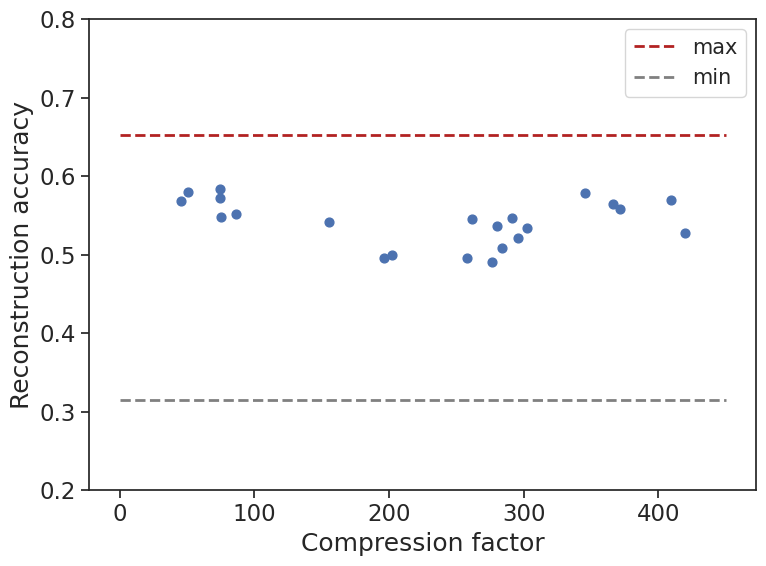

In [88]:
df = pd.concat([pd.DataFrame(mean_r2, index=df_overview.index), df_overview["compressionFactor"]], axis=1, ignore_index=True)
df = df.sort_values(1, ascending=False)
df
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x=df[1],y=df[0], s=40)
ax.hlines(y=np.nanmean(dic_noBott["mean"]), xmin=0, xmax=450,linestyle="dashed", color="firebrick", linewidth=2, label=f"max")#"({np.nanmean(dic_noBott['mean']):.2f})")
ax.hlines(y=np.nanmean(dic_smallBott["mean"]), xmin=0, xmax=450,linestyle="dashed", color="grey",linewidth=2,label=f"min")# ({np.nanmean(dic_smallBott['mean']):.2f})")
ax.legend(fontsize=15)
ax.set_ylim(0.2,0.8)
ax.set_ylabel("Reconstruction accuracy")
ax.set_xlabel("Compression factor")
plt.tight_layout()
plt.savefig(f"figures/finalModels_compressionFactors.png")

In [92]:
pd.DataFrame(dic_noBott["std"])

,0
0,0.183
1,0.179
2,0.170
3,0.181
4,0.181
5,NaN
6,0.179
7,0.177
8,NaN
9,0.179


## Higher compression == higher correlation
Hypothesis: highher compression possible du eto higher (linear) correlation of CpGs on chromosomes --> easier to model

In [5]:
# for CHR in [f"chr{ele}" for ele in range(13,14)]:
#     ### Get input CpGs
#     with open(os.path.join(PATH_data, f"{CHR}_train_methyl_array.pkl"), "rb") as f: train_dataset = pickle.load(f) #  
#     print(train_dataset["beta"].corr().mean().mean())

'''
Noooope, doesn't look like it:

chr22: 0.0409
chr21: 0.0331
chr20: 0.0277

chr1: 0.0318
'''

"\nNoooope, doesn't look like it:\n\nchr22: 0.0409\nchr21: 0.0331\nchr20: 0.0277\n\nchr1: 0.0318\n"

## Higher compression == different beta-value distribution
e.g. more towards 1 / 0, as this should be easier to compute

In [37]:
df_overview.sort_values(by="compressionFactor")[df_overview.sort_values(by="compressionFactor")["compressionFactor"] < 100]

,num_cpgs,hidden_layer_encoder_topology,latentSize,lr,dropout,compressionFactor
chr8,13704,"[4110, 820]",358,0.0001,0.1,38.27933
chr21,2719,"[820, 160]",60,0.0005,0.1,45.316667
chr18,3654,"[1100, 220]",72,0.0005,0.3,50.75
chr6,23070,"[6920, 1380]",428,0.0005,0.1,53.901869
chr20,6567,"[1970, 390]",88,0.0005,0.3,74.625
chr22,5243,"[1570, 310]",70,0.0005,0.3,74.9
chr9,6619,"[1990, 400]",88,0.0005,0.3,75.215909
chr13,7802,"[2340, 470]",90,0.0005,0.3,86.688889


In [139]:
df_overview.sort_values(by="compressionFactor")[df_overview.sort_values(by="compressionFactor")["compressionFactor"] > 100]

,num_cpgs,hidden_layer_encoder_topology,latentSize,lr,dropout,compressionFactor
chr14,9417,"[2830, 570]",48,0.0001,0.1,196.1875
chr15,9715,"[2910, 580]",48,0.0001,0.1,202.395833
chr19,15475,"[4640, 930]",60,0.0001,0.1,257.916667
chr4,13100,"[3930, 790]",50,0.0001,0.1,262.0
chr16,13823,"[4150, 830]",50,0.0001,0.1,276.46
chr7,19599,"[5880, 1180]",70,0.0001,0.1,279.985714
chr17,17044,"[5110, 1020]",60,0.0001,0.1,284.066667
chr12,15165,"[4550, 910]",52,0.0001,0.1,291.634615
chr10,15736,"[4720, 940]",52,0.0001,0.1,302.615385
chr3,15547,"[4660, 930]",45,0.0001,0.1,345.488889


In [211]:
from scipy.stats import wasserstein_distance
from itertools import combinations ,product


chr8
chr1


0.024411005463762767

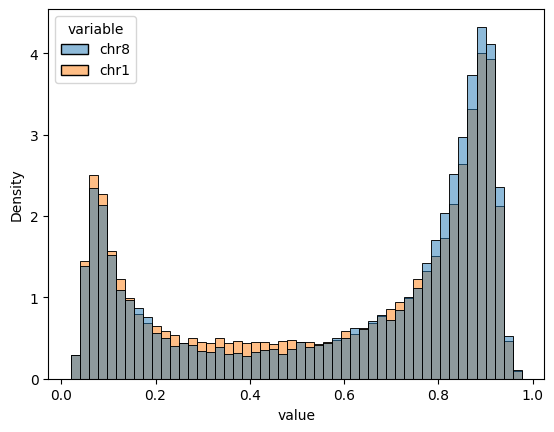

In [270]:
'''
Seems like: 
- low compression chromosomes differ a lot in their beta distrubtion
- high compression chromosomes have similar beta distribution
'''

print(
)

dict_x = dict()
for CHR in [f"chr{ele}" for ele in [8,1]]: #[13,14,15]
    print(CHR)
    ### Get input CpGs
    with open(os.path.join(PATH_data, f"{CHR}_train_methyl_array.pkl"), "rb") as f: train_dataset = pickle.load(f) 
    x = train_dataset["beta"].mean()
    #sns.kdeplot(x)
    dict_x[CHR] = x
    
df = pd.DataFrame.from_dict(dict_x).melt()
sns.histplot(data=df, x="value", hue="variable", common_norm=False, stat="density", bins=50)

'''
Compute difference
''' 
keys = list(dict_x.keys())
wasserstein_distance(dict_x[keys[0]],dict_x[keys[1]]) 

1x large, 1x small (different reduction):
1, 22 - 0.0046
21, 2 - 0.0168
21, 5 - 0.033
21, 11 - 0.0174

2x large reduction:
1, 2 - 0.0095
1, 5 - 0.0100
1, 11 - 0.0064

2x small reduction:
21, 18 - 0.0713
20, 22 - 0.0474

In [272]:
dict_x = dict()
for CHR in [f"chr{ele}" for ele in range(1,23)]: #[13,14,15]
    ### Get input CpGs
    with open(os.path.join(PATH_data, f"{CHR}_train_methyl_array.pkl"), "rb") as f: train_dataset = pickle.load(f) 
    x = train_dataset["beta"].mean()
    dict_x[CHR] = x

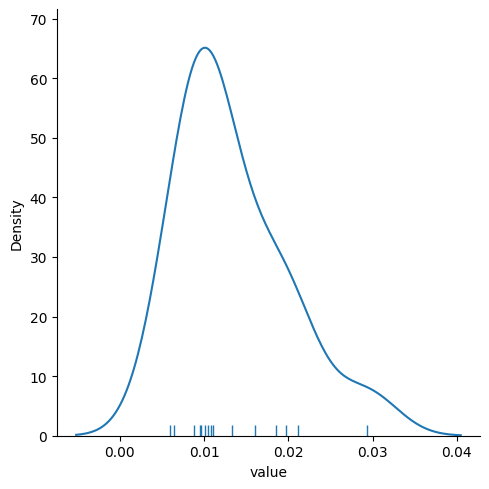

0.013366765895049924


In [248]:
'''
Wasserstein values of Chr with large reduction factors
'''
chr_large = df_overview.sort_values(by="compressionFactor")[df_overview.sort_values(by="compressionFactor")["compressionFactor"] > 300].index.tolist()
df = pd.DataFrame(columns=chr_large, index=chr_large)

for comb in list(combinations(chr_large,2)):
    dis = wasserstein_distance(dict_x[comb[0]],dict_x[comb[1]])
    df.loc[comb[0], comb[1]] = dis

df_large = df.melt()["value"]
#sns.swarmplot(df_large)
sns.displot(df_large, kind="kde", rug=True)
plt.show()

print(df.melt()["value"].mean())

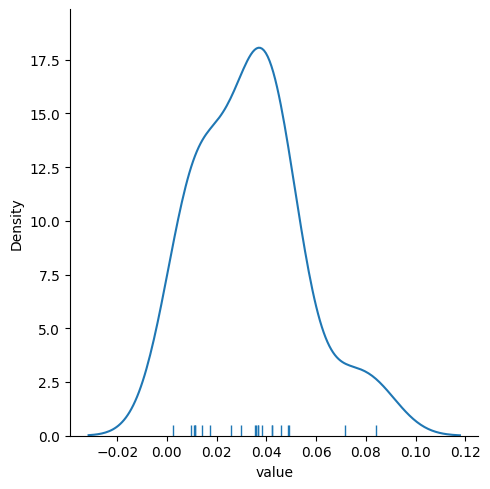

0.03330634091687479


In [263]:
'''
Wasserstein values of Chr with middle reduction factors
'''
x = df_overview.sort_values(by="compressionFactor")
chr_middle = x[(x["compressionFactor"] < 300) & (x["compressionFactor"] > 200)].index.tolist()

df = pd.DataFrame(columns=chr_middle, index=chr_middle)

for comb in list(combinations(chr_middle,2)):
    dis = wasserstein_distance(dict_x[comb[0]],dict_x[comb[1]])
    df.loc[comb[0], comb[1]] = dis

df_middle = df.melt()["value"]
#sns.swarmplot(df_large)
sns.displot(df_middle, kind="kde", rug=True)
plt.show()

print(df.melt()["value"].mean())

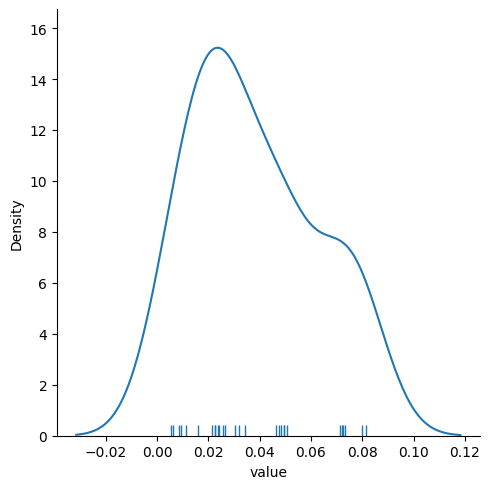

0.037947920020092826


In [264]:
'''
Wasserstein values of Chr with small reduction factors
'''
chr_large = df_overview.sort_values(by="compressionFactor")[df_overview.sort_values(by="compressionFactor")["compressionFactor"] < 100].index.tolist()
df = pd.DataFrame(columns=chr_large, index=chr_large)

for comb in list(combinations(chr_large,2)):
    dis = wasserstein_distance(dict_x[comb[0]],dict_x[comb[1]])
    df.loc[comb[0], comb[1]] = dis

df_small = df.melt()["value"]
# sns.swarmplot(df_small)
sns.displot(df_small, kind="kde", rug=True)
plt.show()

print(df.melt()["value"].mean())

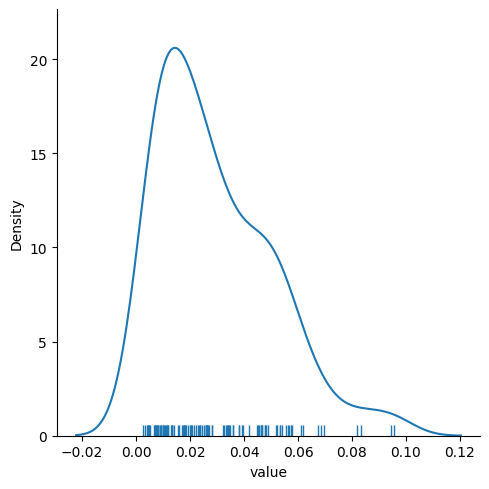

0.029284891531529585


In [273]:
'''
Wasserstein values of Chr with different reduction factors
'''
chr_large = df_overview.sort_values(by="compressionFactor")[df_overview.sort_values(by="compressionFactor")["compressionFactor"] > 100].index.tolist()
chr_small = df_overview.sort_values(by="compressionFactor")[df_overview.sort_values(by="compressionFactor")["compressionFactor"] < 100].index.tolist()


df = pd.DataFrame(columns=chr_large+chr_small, index=chr_large+chr_small)

for comb in list(product(chr_large, chr_small)):
    dis = wasserstein_distance(dict_x[comb[0]],dict_x[comb[1]])
    df.loc[comb[0], comb[1]] = dis

df_mixed = df.melt()["value"]
sns.displot(df_mixed, kind="kde", rug=True)
plt.show()

print(df.melt()["value"].mean())

In [274]:
df

,chr14,chr15,chr19,chr4,chr16,chr7,chr17,chr12,chr10,chr3,...,chr1,chr5,chr8,chr21,chr18,chr6,chr20,chr22,chr9,chr13
chr14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.020375,0.019912,0.051913,0.003429,0.053191,0.011574,0.007115,0.028175
chr15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.026696,0.025908,0.045544,0.004536,0.04677,0.008813,0.003961,0.034523
chr19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.061886,0.061015,0.017634,0.03963,0.011634,0.035935,0.038155,0.069807
chr4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.020822,0.023584,0.052073,0.007199,0.053342,0.01828,0.01338,0.027973
chr16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.022196,0.023092,0.094367,0.044828,0.095645,0.048164,0.046188,0.020329
chr7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.009857,0.010889,0.082023,0.032497,0.083295,0.035827,0.033896,0.007939
chr17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.018312,0.016059,0.056203,0.010955,0.057478,0.010109,0.008245,0.026303
chr12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.026919,0.026184,0.045327,0.0044,0.046602,0.010329,0.005195,0.034696
chr10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.007613,0.012903,0.067425,0.017893,0.0687,0.021399,0.01936,0.013991
chr3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.025929,0.025125,0.046438,0.004689,0.047616,0.013338,0.008185,0.033764


Ttest_indResult(statistic=-3.87242897035196, pvalue=0.00037981376228729357)
Ttest_indResult(statistic=-3.5919887746078962, pvalue=0.0010245195137117311)
Ttest_indResult(statistic=0.7092289250050255, pvalue=0.4816860054117482)


<AxesSubplot:xlabel='value', ylabel='Density'>

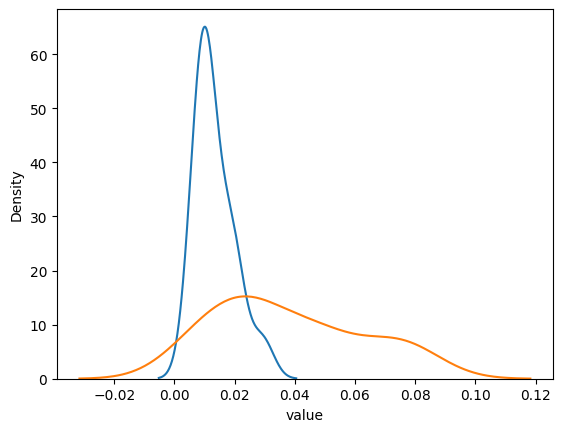

In [268]:
from scipy.stats import ttest_ind
print(ttest_ind(df_large[df_large.notna()], df_small[df_small.notna()]))
print(ttest_ind(df_large[df_large.notna()], df_middle[df_middle.notna()]))
print(ttest_ind(df_small[df_small.notna()], df_middle[df_middle.notna()]))

fig, ax = plt.subplots()
sns.kdeplot(df_large, ax=ax)
#sns.kdeplot(df_middle, ax=ax)
sns.kdeplot(df_small, ax=ax)

In [146]:
keys = list(dict_x.keys())
a = pd.Series(dict_x[keys[0]]).value_counts(normalize=True, bins=[0,0.15,0.3,0.6,0.8,1]).sort_index()
b = pd.Series(dict_x[keys[1]]).value_counts(normalize=True, bins=[0,0.15,0.3,0.6,0.8,1]).sort_index()

a-b

(-0.001, 0.15]    0.016803
(0.15, 0.3]       0.006577
(0.3, 0.6]        0.001640
(0.6, 0.8]       -0.011744
(0.8, 1.0]       -0.013276
dtype: float64

In [142]:
keys = list(dict_x.keys())
a = pd.Series(dict_x[keys[0]]).value_counts(normalize=True, bins=np.linspace(0,1,50)).sort_index()
b = pd.Series(dict_x[keys[1]]).value_counts(normalize=True, bins=np.linspace(0,1,50)).sort_index()

abs(a-b).sum()

0.1190621136132321

In [123]:
from scipy.stats import wasserstein_distance

In [124]:
wasserstein_distance(dict_x[keys[0]],dict_x[keys[1]]) 

0.004658312885261187

In [34]:
pd.Series(dict_x["chr22"]).value_counts(normalize=True, bins=[0,.3,.6,1]).sort_index()

(-0.001, 0.3]    0.282663
(0.3, 0.6]       0.139996
(0.6, 1.0]       0.577341
dtype: float64

In [50]:
# import itertools
# df = pd.DataFrame(index=dict_x.keys(), columns=dict_x.keys())
# for ele in list(itertools.combinations(dict_x.keys(), 2)):
#     df.loc[ele[0], ele[1]] = ttest_ind(dict_x[ele[0]], dict_x[ele[1]])[1]

## Ratio of perturbed CpGs (high, medium, low, none) different between Chromosomes?